In [2]:
from DSSATTools import run
import os
import tempfile
import pandas as pd
from datetime import datetime, timedelta
import copy
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from DSSATTools import dssatUtils
import tqdm
from tradssat import (
    SoilFile, WTHFile, ExpFile,
    GeneticMgr, CULFile, ECOFile
)

import warnings
warnings.filterwarnings('ignore')

# Set some Model files using tradssat

## Set Irrigation and Experiment Parameters

In [3]:
irrigation = pd.read_excel('/mnt/c/Users/dandres/Documents/Class_projects/Alfalfa_Weather/Irrigations.xlsx', 'Sheet1')
irrigation = irrigation.loc[irrigation.treat.isin([100, 80, 60])]
irrigation['I'] = irrigation.treat.replace({100: 1, 80: 2, 60: 3})
irrigation['IDATE'] = irrigation.date.dt.strftime('%y%j')
irrigation['IRVAL'] = irrigation.irrig * 25.4
irrigation['IROP'] = 'IR005' # Drip tape

In [4]:
experimetal_file = 'test/AGZG1501.ALX'
exp = ExpFile(experimetal_file)

### Irrigation

In [5]:
# Add subsections
irr_subsect = exp._values._sections['IRRIGATION AND WATER MANAGEMENT']._subsections
names = ['VR100', 'VR080', 'VR060']
for i in range(len(names)-len(irr_subsect)//2):
    exp._values._sections['IRRIGATION AND WATER MANAGEMENT']._subsections += copy.deepcopy(irr_subsect[:2])

In [6]:
n = 0
for i in range(len(names)*2):
    if i % 2 == 1:
        continue
    exp.remove_row(sect='IRRIGATION AND WATER MANAGEMENT', subsect=i)
    exp.remove_row(sect='IRRIGATION AND WATER MANAGEMENT', subsect=i+1)
    n += 1
    df = irrigation.loc[irrigation.I == n]
    exp.add_row(
        sect='IRRIGATION AND WATER MANAGEMENT',
        vals= {
            'EFIR': 1, 'IDEP': 50, 'ITHR': 50, 'IEPT': 100, 'IOFF': 'GS000',
            'IAME': 'IR005', 'IAMT': 10, 'IRNAME': names[n-1], 'I': i+1
        },
        subsect=i
    )
    exp.add_row(
        sect='IRRIGATION AND WATER MANAGEMENT',
        vals= {
            'IDATE': df.IDATE.to_numpy(), 'I': df.I.to_numpy(), 
            'IRVAL': df.IRVAL.round(1).to_numpy(), 'IROP': df.IROP.to_numpy(),
        },
        subsect=i+1
    )

### Planting parameters

In [7]:
exp.set_value('PDATE', int(datetime(2020, 9, 8).strftime('%y%j'))) # Planting Date
exp.set_value('EDATE', int(datetime(2020, 9, 17).strftime('%y%j'))) # Emergence Date
exp.set_value('PLDP', 1) # Planting Depth
exp.set_value('TDATE', int(datetime(2020, 8, 10).strftime('%y%j'))) # Tillage
exp.set_value('HDATE', int(datetime(2021, 9, 30).strftime('%y%j')))

In [8]:
# exp.write('test/UNVR2001.ALX')

----------------

## Mowing file (Harvest)

In [9]:
yld = irrigation = pd.read_excel('/mnt/c/Users/dandres/Documents/Class_projects/Alfalfa_Weather/Yield_data.xlsx', 'Yield')
yld = yld.loc[yld.Water.isin([100, 80, 60])]
yld = yld.sort_values(by=['Water', 'Cutting'])
yld['rep'] = list(range(6)) * (len(yld)//6)
yld.Harvest_date.dt.strftime('%y%j').unique()

array(['21166', '21196', '21228', '21266'], dtype=object)

--------------------------------------
## Weather files

In [10]:
weather = pd.read_pickle('/mnt/c/Users/dandres/Documents/Code/UNR_daily_weather_data_2000_2021.pkl')
# weather = weather.loc[weather['loc'] == 'Valley_Road']
weather['SRAD'] = weather.TotalSolarRadKWhrm *3.6
weather['SRAD'] = np.where(weather.SRAD < 4, np.nan, weather.SRAD)
weather['TMAX'] = weather.AirTemperatureMaxDegC
weather['TMIN'] = weather.AirTemperatureMinDegC
weather['RAIN'] = weather.TotalPrecipmm
weather['DEWP'] = weather.DewPointDegC
weather['RHUM'] = weather.RelativeHumidityMeanPercent
weather['WIND'] = weather.WindAvems *86.4
weather['DATE'] = weather.index.strftime('%y%j')
weather['PAR'] = -99
weather['EVAP'] = -99
weather = weather.iloc[:, -10:]
weather = weather.interpolate()
weather

,SRAD,TMAX,TMIN,RAIN,DEWP,RHUM,WIND,DATE,PAR,EVAP
time,,,,,,,,,,
2000-01-01,8.388,8.2,-7.8,0.00,-6.450000,64.500000,182.520000,00001,-99,-99
2000-01-02,9.540,4.9,-10.2,0.00,-7.191667,67.250000,143.280000,00002,-99,-99
2000-01-03,10.188,9.7,-1.7,0.00,-4.112500,60.708333,82.800000,00003,-99,-99
2000-01-04,7.344,9.5,-4.6,0.00,-4.433333,62.083333,201.240000,00004,-99,-99
2000-01-05,10.800,5.3,-6.6,0.00,-7.233333,65.166667,111.600000,00005,-99,-99
...,...,...,...,...,...,...,...,...,...,...
2021-10-10,18.504,22.3,-0.1,0.00,-1.691667,45.375000,132.480000,21283,-99,-99
2021-10-11,15.660,12.0,0.2,2.28,-3.804167,58.958333,414.720000,21284,-99,-99
2021-10-12,19.368,11.1,-1.9,0.00,-7.850000,43.666667,150.480000,21285,-99,-99


In [11]:
wth = WTHFile('weather/UNVR1501.WTH')

In [12]:
year = 2000
for year in weather.index.year.unique():
    df = weather.loc[weather.index.year == year]
    wth.remove_row('WEATHER DATA : UNR, VALLEY ROAD')
    wth.add_row(
        sect='WEATHER DATA : UNR, VALLEY ROAD', subsect=0,
        vals={
            'INSI': 'UNVR', 'LAT': 33.530, 'LONG': -119.800, 
            'ELEV': 1365,
        }
    )
    wth.add_row(
        sect='WEATHER DATA : UNR, VALLEY ROAD', subsect=1,
        vals={var: df[var] for var in df.columns}
    )
    wth.write(f'weather/UNVR{str(year)[2:]}01.WTH')
exp.set_value('WSTA', 'UNVR')
# exp.write('test/UNVR2001.ALX')

------------------
## Run Model the model

In [16]:
os.chdir('/home/diego/Py_DSSATTools')
CMSRun = run.CSM_EXE(
    DSSATExe='/mnt/c/DSSAT47/DSCSM047.EXE',
    verbose=True
)
CMSRun.runDSSAT(
    experimental='test/UNVR2001.ALX',
    crop='AL', 
    wth_folder='weather/',
    soil_profile='test/ValleyRoad.SOL',
    wdir=os.path.join(os.getcwd(), 'wdir')
)

DSSAT Executable at /mnt/c/DSSAT47/DSCSM047.EXE

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 AL   1 -99 -99   -99 12964    70  1805  1886    21   -99   173  12165  120


RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 AL   2 -99 -99   -99 10625    70  1534  1666     0   -99   335  12205  121


RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 AL   3 -99 -99   -99  8121    70  1259  1397     0   -99   528  12253  121




    *FORAGES
    @CDE   LABEL           DESCRIPTION............................................  SYNONYMS
    FHC%H  Harv. For.%CH2O Harvested forage carbohydrate concentration at harvest (percent CH2O)
    FHLGH  Harv. For. Lig. Harvested forage lignin concentration at forage harvest (percent lignin)
    FHL%H  Harv. For. %Lf  Harvested forage leaf percentage at forage harvest (percent leaf)
    FHN%H  Harv. For. %N   Harvested forage nitrogen concentration at forage harvest (percent N)
    FHNAH  Harv. For. N    Harvested forage nitrogen weight at forage harvest (kg N/ha)
    FHNO   Forage harvest  Count of forage harvests within current run
    FHWAH  Harv. For. Wt.  Harvested forage weight (leaf + stem) at forage harvest (kg/ha)
    RCWAH  Resid. Can. Wt. Residual canopy weight after forage harvest (kg/ha)
    RLAIH  Resid. LAI      Residual leaf area index after forage harvest
    RLWAH  Resid. Leaf Wt. Residual leaf weight after forage harvest (kg/ha)
    RSWAH  Resid. Stem Wt. Residual stem weight after forage harvest (kg/ha)
    RSRWH  Resid. Stor.Wt. Residual storage organ weight after forage harvest (kg/ha)
    RRTWH  Resid. Root Wt. Residual root weight after forage harvest (kg/ha)
    RLAIH  Resid. LAI      Residual leaf area index after forage harvest

In [17]:
results = pd.concat([CMSRun.results.getOutput('FORAGE', str(i)) for i in [1, 2, 3]], ignore_index=True)
results.iloc[:, 3:] = results.iloc[:, 3:].astype(float)
results.TRNO = results.TRNO.replace({1:100, 2:80, 3:60})
results['DATE'] = [datetime(2021, 1, 1) + timedelta(days=doy-1) for doy in results.DOY]
results

,@RUN,FILEX,CR,TRNO,FHNO,YEAR,DOY,RCWAH,RLWAH,RSWAH,RSRWH,RRTWH,RLAIH,FHWAH,FHNAH,FHN%H,FHC%H,FHLGH,FHL%H,DATE
0,1,UNVR2001,AL,100,1.0,2021.0,166.0,1000.0,200.0,800.0,1307.0,3606.0,0.51,3611.0,108.0,2.98,4.45,6.0,72.0,2021-06-15
1,1,UNVR2001,AL,100,2.0,2021.0,196.0,1000.0,200.0,800.0,1515.0,3643.0,0.57,2724.0,104.0,3.8,4.08,4.89,86.8,2021-07-15
2,1,UNVR2001,AL,100,3.0,2021.0,228.0,1000.0,200.0,800.0,1800.0,3856.0,0.63,3177.0,112.0,3.54,4.45,5.76,75.3,2021-08-16
3,1,UNVR2001,AL,100,4.0,2021.0,266.0,1000.0,200.0,800.0,2197.0,4333.0,0.59,3450.0,122.0,3.54,4.7,6.18,69.6,2021-09-23
4,1,UNVR2001,AL,80,1.0,2021.0,166.0,1000.0,200.0,800.0,1149.0,3151.0,0.5,2857.0,89.0,3.13,4.18,5.61,77.2,2021-06-15
5,1,UNVR2001,AL,80,2.0,2021.0,196.0,1000.0,200.0,800.0,1319.0,2754.0,0.57,2320.0,92.0,3.96,3.87,4.41,93.2,2021-07-15
6,1,UNVR2001,AL,80,3.0,2021.0,228.0,1000.0,200.0,800.0,1547.0,2962.0,0.59,2559.0,97.0,3.78,4.18,5.09,84.1,2021-08-16
7,1,UNVR2001,AL,80,4.0,2021.0,266.0,1000.0,200.0,800.0,1848.0,3249.0,0.55,2889.0,110.0,3.8,4.32,5.36,80.5,2021-09-23
8,1,UNVR2001,AL,60,1.0,2021.0,166.0,1000.0,200.0,800.0,988.0,2715.0,0.5,2109.0,68.0,3.22,3.95,5.09,84.2,2021-06-15
9,1,UNVR2001,AL,60,2.0,2021.0,196.0,1000.0,200.0,800.0,1098.0,2284.0,0.56,1833.0,75.0,4.09,3.74,4.12,97.0,2021-07-15


(0.0, 22.0)

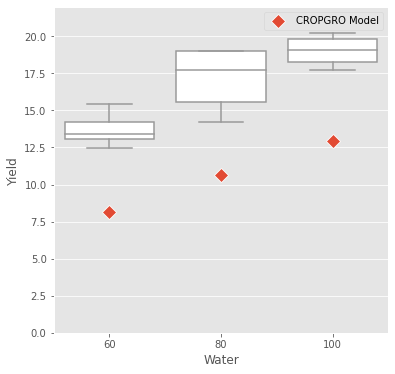

In [18]:
plt.style.use('ggplot')
figure, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
df = yld.groupby(['Water', 'rep']).agg({'Yield': 'sum'}).reset_index()
sns.boxplot(
    x=df.Water,
    y=df.Yield, 
    ax=ax, color='w'
)
sns.scatterplot(
    x=[0, 1, 2],
    y=results.sort_values(by='TRNO', ascending=False).groupby('TRNO').agg({'FHWAH': 'sum'}).FHWAH/1000,
    ax=ax, marker="D", s=100, label='CROPGRO Model'
)
ax.set_ylim(0, 22)
# ax.set_yscale('log')

In [19]:
results.sort_values(by='TRNO', ascending=False).groupby('TRNO').agg({'FHWAH': 'sum'})

,FHWAH
TRNO,
60,8121.0
80,10625.0
100,12962.0


### Some insight about the bayesian Framework

Let's assume we have the model $\hat{Y} = F(X_1, X_2,\cdots, X_N)$. Every parameter of the model $X_i$ is assumed to be random variable. The idea is to find the distribution of the parameter (Posterior) based on the experimental data (Likelihood) and some prior information (Prior).

$$
\begin{aligned}
P(X_i|Y) = \frac{P(Y|X_i)P(X_i)}{P(Y)}
\end{aligned}
$$

<p align="center">
  <img src="https://miro.medium.com/max/839/1*uivjxg-_jmSpFqxwWH80DA.png" />
</p>

- Understand model Ecotype, Species and Cultivar parameters. Establish a good starting point based on that understanding.
- Set up a sensititivy analysis framework, and perform a sensitivity analisis to determine the priorized parameters (Fourier amplitude sensitivity testing). 
- Set up the calibration framework and perform the calibratoin.


-----------------
## Simulation results analysis

In [20]:
CMSRun.results.keys()

dict_keys(['1', '2', '3'])

In [21]:
CMSRun.results.getOutput('Dormancy', '1')

,@YEAR,DOY,DAS,DAP,QDSD,PPGF,PPMF,PPTF,TSRD,TS1D,FRZ2,LV%D,SV%D,QV%D,RV%D
0,2020,252,143,0,DORM,1.000,1.000,0.053,0.0,32.8,-11.0,0.350,0.200,0.010,0.440
1,2020,253,144,1,DORM,1.000,1.000,0.054,0.0,30.2,-11.0,0.339,0.194,0.041,0.426
2,2020,254,145,2,DORM,1.000,1.000,0.055,0.0,28.4,-11.0,0.186,0.103,0.022,0.689
3,2020,255,146,3,DORM,1.000,1.000,0.056,0.0,27.7,-11.0,0.343,0.189,0.042,0.426
4,2020,256,147,4,DORM,1.000,1.000,0.057,0.0,27.1,-11.0,0.343,0.189,0.042,0.426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,2021,269,526,383,DORM,1.000,1.000,0.070,0.0,25.2,-11.0,0.532,0.161,0.115,0.192
384,2021,270,527,384,DORM,1.000,1.000,0.071,0.0,25.1,-11.0,0.532,0.161,0.116,0.192
385,2021,271,528,385,DORM,1.000,1.000,0.072,0.0,23.8,-11.0,0.531,0.161,0.116,0.192
386,2021,272,529,386,DORM,1.000,1.000,0.073,0.0,23.6,-11.0,0.531,0.161,0.117,0.192


In [22]:
def return_table(output, treats=[1, 2, 3]):
    df =  pd.concat([CMSRun.results.getOutput(output, str(i)) for i in treats], ignore_index=True)
    df.loc[:, 'DATE'] = [
        datetime(year, 1, 1) + timedelta(days=int(doy)-1) 
        for year, doy in zip(df['@YEAR'].astype(int), df.DOY.astype(int))
    ]
    df = df.set_index('DATE')
    return df
treat = 3
growth = return_table('PlantGro', treats=[3])
growth

,@YEAR,DOY,DAS,DAP,L#SD,GSTD,LAID,LWAD,SWAD,QWAD,...,SDAD,QDAD,HERB,FHL%,LF%D,DWTCO,DWTLO,DWTSO,CHTCM,CPROT
DATE,,,,,,,,,,,,,,,,,,,,,
2020-09-08,2020,252,143,0,0.0,0,0.00,0,0,0,...,0,0,0,0.0,0.0,0,0,0,0,0.00
2020-09-09,2020,253,144,1,0.1,0,0.04,23,13,1,...,0,0,0,0.0,63.7,0,0,0,6,0.00
2020-09-10,2020,254,145,2,0.2,0,0.04,24,14,1,...,0,0,0,0.0,63.5,0,0,0,6,0.00
2020-09-11,2020,255,146,3,0.3,0,0.05,26,15,1,...,0,0,0,0.0,63.4,0,0,0,6,0.00
2020-09-12,2020,256,147,4,0.5,0,0.05,28,16,1,...,0,0,0,0.0,63.3,0,0,0,7,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-26,2021,269,526,383,2.4,0,0.83,333,803,1423,...,1264,1171,0,0.0,29.3,0,0,0,7,0.00
2021-09-27,2021,270,527,384,2.4,0,0.83,349,802,1416,...,1266,1179,0,0.0,30.3,0,0,0,7,0.00
2021-09-28,2021,271,528,385,2.5,0,0.84,362,805,1413,...,1268,1183,0,0.0,31.0,0,0,0,7,0.00


In [23]:
ET = return_table('ET')
Dormancy = return_table('Dormancy', treats=[3])

In [24]:
CMSRun.results.getOutput('Dormancy', treat='1').columns

Index(['@YEAR', 'DOY', 'DAS', 'DAP', 'QDSD', 'PPGF', 'PPMF', 'PPTF', 'TSRD',
       'TS1D', 'FRZ2', 'LV%D', 'SV%D', 'QV%D', 'RV%D'],
      dtype='object')

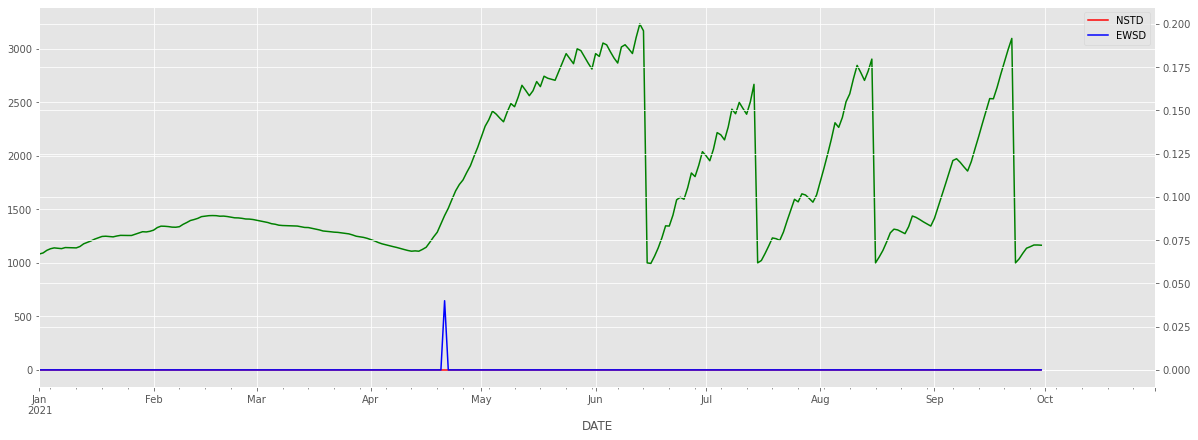

In [25]:
fig, ax = plt.subplots(figsize=(20, 7))
growth.CWAD.astype(float).plot(ax=ax, c='g')
ax2 = ax.twinx()
(growth.NSTD.astype(float)).plot(ax=ax2, c='r')
(growth.EWSD.astype(float)).plot(ax=ax2, c='b') 

# ET.TMAXA.astype(float).plot(ax=ax2, c='k', style='--')
# ET.TMINA.astype(float).plot(ax=ax2, c='k', style='--')
# (5000 * ET.EPAA.astype(float)/ET.EOPA.astype(float)).plot(ax=ax)
ax.set_xlim(datetime(2021, 1, 1), datetime(2021, 10, 31))
ax2.legend()

## Try some parameter tunning

In [34]:
# os.chdir('/home/diego/Py_DSSATTools')
results = {1:[], 2:[], 3:[]}
CropFile = dssatUtils.CropParser('test/ALFRM047.SPE', raise_missing_pars=False)
CMSRun = run.CSM_EXE(
    DSSATExe='/mnt/c/DSSAT47/DSCSM047.EXE',
    verbose=False
)
for EORATIO in tqdm.tqdm_notebook(np.linspace(0.5, 4, 20)):
    CropFile.set_parameter('EORATIO', EORATIO),
    CropFile.write('ALFRM047')
    CMSRun.runDSSAT(
        experimental='test/UNVR2001.ALX',
        crop='AL', 
        wth_folder='weather/',
        soil_profile='test/ValleyRoad.SOL',
        wdir=os.path.join(os.getcwd(), 'wdir'),
        crop_file='ALFRM047.SPE',
        treatments=[1, 2, 3]
    )
    for treat in [1, 2, 3]:
        results[treat].append(CMSRun.results.getOutput('FORAGE', str(treat)))
    

DSSAT Executable at /mnt/c/DSSAT47/DSCSM047.EXE


  0%|          | 0/20 [00:00<?, ?it/s]

In [27]:
results_cp = copy.deepcopy(results)

In [28]:
plot_df = pd.DataFrame(
    [[df.FHWAH.astype(float).sum() for df in results[treat]] for treat in [1, 2, 3]],
    index=[2, 1, 0]
).T
plot_df = plot_df.melt(value_vars=[0, 1, 2])
plot_df['EORATIO'] = 3 * list(np.linspace(0.5, 4, 20))

(0.0, 22.0)

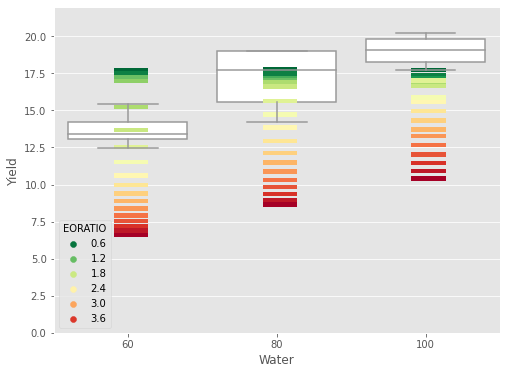

In [29]:
plt.style.use('ggplot')
figure, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
df = yld.groupby(['Water', 'rep']).agg({'Yield': 'sum'}).reset_index()
sns.boxplot(
    x=df.Water,
    y=df.Yield, 
    ax=ax, color='w'
)
sns.scatterplot(
    x=plot_df.variable, y=plot_df.value/1000,
    ax=ax, hue=plot_df.EORATIO, palette='RdYlGn_r', marker='$-$',
    s=1600, linewidth=0
    
)
ax.set_ylim(0, 22)

In [30]:
plot_df['obs_mean'] = plot_df.variable.map(df.groupby('Water').mean().reset_index()['Yield'])
plot_df['dif'] = abs(plot_df.value/1000 - plot_df.obs_mean) / plot_df.obs_mean
plot_df['Treatment'] = plot_df.variable.map({0: 60, 1: 80, 2: 100})

(0.0, 0.6)

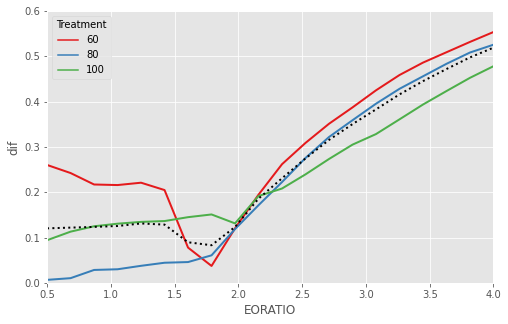

In [31]:
figure, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))
# ax.plot([0, 4], [0, 0], 'k--')
sns.lineplot(
    x=plot_df.EORATIO, y=plot_df.dif, hue=plot_df.Treatment,
    palette='Set1', ax=ax, linewidth=2
)
plot_df.groupby('EORATIO').mean().dif.plot(style='k:', ax=ax, linewidth=2)
ax.set_xlim(0.5, 4); ax.set_ylim(0., .6)

In [181]:
help(run.CSM_EXE)

Help on class CSM_EXE in module DSSATTools.run:

class CSM_EXE(builtins.object)
 |  CSM_EXE(DSSATExe='/mnt/c/DSSAT47/DSCSM047.EXE', verbose=False, **kwargs)
 |  
 |  A class to handle the DSSAT execution
 |  ...
 |  Attributes
 |  ----------------------
 |  results: dssatUtils.DSSATOutput object
 |      It is a dict-like type object. Upper level key is the treatment, nested keys are
 |      the results section (PlantGro, Summary, Etc.)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, DSSATExe='/mnt/c/DSSAT47/DSCSM047.EXE', verbose=False, **kwargs)
 |      Initialization of the DSSAT environment
 |      ...
 |      Arguments
 |      ---------------------
 |      DSSATExe: str
 |          Path to the DSSAT Executable file
 |      verbose: bool
 |          Whether to print the DSSAT execution output or not.
 |  
 |  runDSSAT(self, experimental, crop, treatments=None, wth_folder=None, soil_profile=None, wdir=None, crop_file=None)
 |      Runs DSSAT based on the passed arguments to th